# Pricing EV Charging Service with Demand Charge
## Zachary Lee, John Pang, Steven Low
### Last Updated: 4/18/2020

The purpose of this notebook is to plot results for pricing EV charging services with demand charge in both the offline and online domains. 

In [1]:
import numpy as np
import pandas as pd
import json 
import pickle
from matplotlib import pyplot as plt
from pprint import pprint

### Plotting Functions

In [2]:
from matplotlib import cm

def plot_cost_rev_offline(results, ax):
    zeros = [0] * results.shape[0]
    cmap = cm.get_cmap('tab20')
    evse = pd.DataFrame({'Cost': zeros, 
                         'Revenue': results['revenue.charger_congestion']})
    congestion = pd.DataFrame({'Cost': zeros, 
                         'Revenue': results['revenue.network_congestion']})
    energy = results[['costs.energy_cost', 'revenue.energy']]
    energy.columns = ['Cost', 'Revenue']
    demand = results[['costs.demand_charge', 'revenue.demand_charge']]
    demand.columns = ['Cost', 'Revenue']

    lw = 0
    (energy + demand + congestion + evse).plot.bar(ax=ax, color=[cmap(6), cmap(7)], legend=False, edgecolor='white', linewidth=lw)
    (energy + demand + congestion).plot.bar(ax=ax, color=[cmap(4), cmap(5)], legend=False, edgecolor='white', linewidth=lw)
    (energy + demand).plot.bar(ax=ax, color=[cmap(2), cmap(3)], legend=False, edgecolor='white', linewidth=lw)
    energy.plot.bar(ax=ax, color=[cmap(0), cmap(1)], legend=False, rot=0, edgecolor='white', linewidth=lw)


def plot_cost_rev_online(offline_results, online_results, ax):
    zeros = [0] * offline_results.shape[0]
    cmap = cm.get_cmap('tab20')
    evse = pd.DataFrame({'Cost': zeros, 
                         'Revenue': offline_results['revenue.charger_congestion']})
    congestion = pd.DataFrame({'Cost': zeros, 
                               'Revenue': offline_results['revenue.network_congestion']})
    energy = pd.DataFrame({'Cost': online_results['energy_cost'], 
                         'Revenue': offline_results['revenue.energy']})
    demand = pd.DataFrame({'Cost': online_results['demand_charge'], 
                               'Revenue': offline_results['revenue.demand_charge']})
    lw = 0
    (energy + demand + congestion + evse).plot.bar(ax=ax, color=[cmap(6), cmap(7)], legend=False, edgecolor='white', linewidth=lw)
    (energy + demand + congestion).plot.bar(ax=ax, color=[cmap(4), cmap(5)], legend=False, edgecolor='white', linewidth=lw)
    (energy + demand).plot.bar(ax=ax, color=[cmap(2), cmap(3)], legend=False, edgecolor='white', linewidth=lw)
    energy.plot.bar(ax=ax, color=[cmap(0), cmap(1)], legend=False, rot=0, edgecolor='white', linewidth=lw)
    
def plot_cost_rev_online_offline(offline_results, online_results, ax, lw, bw):
    zeros = [0] * offline_results.shape[0]
    cmap = cm.get_cmap('tab20c')
    evse = pd.DataFrame({'Offline Cost': zeros, 
                         'Online Cost': zeros, 
                         'Revenue': offline_results['revenue.charger_congestion']})
    congestion = pd.DataFrame({'Offline Cost': zeros, 
                               'Online Cost': zeros, 
                               'Revenue': offline_results['revenue.network_congestion']})
    energy = pd.DataFrame({ 'Offline Cost': offline_results['costs.energy_cost'],
                             'Online Cost': online_results['energy_cost'], 
                             'Revenue': offline_results['revenue.energy']})
    demand = pd.DataFrame({ 'Offline Cost': offline_results['costs.demand_charge'],
                            'Online Cost': online_results['demand_charge'], 
                               'Revenue': offline_results['revenue.demand_charge']})
    (energy + demand + congestion + evse).plot.bar(ax=ax, color=[cmap(12), cmap(12), cmap(14)], legend=False, edgecolor='white', linewidth=lw, width=bw)
    (energy + demand + congestion).plot.bar(ax=ax, color=[cmap(8), cmap(9), cmap(10)], legend=False, edgecolor='white', linewidth=0, width=bw)
    (energy + demand).plot.bar(ax=ax, color=[cmap(4), cmap(5), cmap(6)], legend=False, edgecolor='white', linewidth=0, width=bw)
    energy.plot.bar(ax=ax, color=[cmap(0), cmap(1), cmap(2)], legend=False, rot=0, edgecolor='white', linewidth=0, width=bw)

### Offline Scheduling and Pricing

In this experiment we consider prices determined at the end of the month. 
For scheduling we assume offline perfect information. 
We consider the cost of the schedule, revenue from users, and surplus for the operator. 

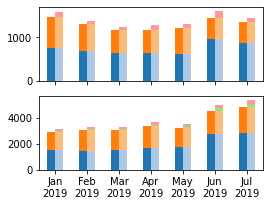

In [4]:
EXPERIMENT_DIR = 'results/offline_prices/'

dates = [f'{m}-1-2019' for m in range(1, 9)] 
sites = ['caltech', 'jpl']
tariff_name = 'sce_tou_ev_4_march_2019'

data = dict()
for site in sites:
    data[site] = dict()
    for start in dates[:-1]:
        path = EXPERIMENT_DIR + f'{tariff_name}/{site}/{start}/'
        with open(path + 'agg_rev.json', 'r') as f:
            agg_rev = json.load(f)   
        with open(path + 'costs.json', 'r') as f:
            costs = json.load(f)
        data[site][start] = dict()
        data[site][start].update({f'revenue.{key}': val for key, val in agg_rev.items()})
        data[site][start].update({f'costs.{key}': val for key, val in costs.items()})

caltech_offline = pd.DataFrame(data['caltech']).T
caltech_offline.index = pd.to_datetime(caltech_offline.index)

jpl_offline = pd.DataFrame(data['jpl']).T
jpl_offline.index = pd.to_datetime(jpl_offline.index)

fig, axes = plt.subplots(2, figsize=(4, 3), sharex=True)
plot_cost_rev_offline(caltech_offline, axes[0])
plot_cost_rev_offline(jpl_offline, axes[1])

axes[1].set_xticklabels([pandas_datetime.strftime("%b\n%Y") for pandas_datetime in caltech_offline.index])
axes[1].set_xlabel('')
pass

In [15]:
fig.savefig('offline_revenue.pdf', dpi=300)

#### Surplus Calculations

In [5]:
print('Caltech Operator Surplus (Online)')
caltech_offline_surplus = caltech_offline['revenue.total'] - caltech_offline['costs.total_cost']
pprint(caltech_offline_surplus)
print(caltech_offline_surplus.mean())
sum(caltech_offline_surplus) 

Caltech Operator Surplus (Online)
2019-01-01    113.567051
2019-02-01     82.188759
2019-03-01     64.328461
2019-04-01     92.551362
2019-05-01     94.686200
2019-06-01    164.612724
2019-07-01     98.813617
dtype: float64
101.53545320311397


710.7481724217978

In [6]:
print('JPL Operator Surplus (Online)')
jpl_offline_surplus = jpl_offline['revenue.total'] - jpl_offline['costs.total_cost']
pprint(jpl_offline_surplus)
print(jpl_offline_surplus.mean())
sum(jpl_offline_surplus) 

JPL Operator Surplus (Online)
2019-01-01    189.973657
2019-02-01    266.826705
2019-03-01    214.693905
2019-04-01    283.910821
2019-05-01    249.750063
2019-06-01    471.509981
2019-07-01    593.738995
dtype: float64
324.3434466970893


2270.404126879625

#### Variation in Optimal Peaks

In [46]:
print('Caltech Variation in Optimal Peaks')
caltech_peaks = caltech_offline['costs.demand_charge'] / 15.51
for i in range(len(caltech_peaks) - 1):
    variation = (caltech_peaks[i+1] - caltech_peaks[i]) / caltech_peaks[i]
    print(f'{i+1}/2019: {variation:.04f}')

Caltech Variation in Optimal Peaks
1/2019: -0.1528
2/2019: -0.1441
3/2019: 0.0149
4/2019: 0.1078
5/2019: -0.1616
6/2019: -0.0399


In [47]:
print('JPL Variation in Optimal Peaks')
jpl_peaks = jpl_offline['costs.demand_charge'] / 15.51
for i in range(len(jpl_peaks) - 1):
    variation = (jpl_peaks[i+1] - jpl_peaks[i]) / jpl_peaks[i]
    print(f'{i+1}/2019: {variation:.04f}')

JPL Variation in Optimal Peaks
1/2019: 0.1468
2/2019: -0.0676
3/2019: 0.1111
4/2019: -0.1087
5/2019: 0.1683
6/2019: 0.1290


#### Overall Results

In [48]:
caltech_offline

,revenue.energy,revenue.demand_charge,revenue.charger_congestion,revenue.network_congestion,revenue.session_price,revenue.total,revenue.energy_delivered,revenue.energy_requested,costs.energy_cost,costs.demand_charge,costs.total_cost
2019-01-01,757.496018,717.505115,111.694995,1.872056,1588.568183,1588.568183,10205.622126,10205.622126,757.496018,717.505115,1475.001133
2019-02-01,694.579894,607.877417,77.559089,4.629656,1384.646024,1384.646056,9283.215764,9283.215764,694.579894,607.877403,1302.457297
2019-03-01,652.728232,520.267875,63.831744,0.496703,1237.324511,1237.324554,8893.327035,8893.327035,652.728232,520.267861,1172.996093
2019-04-01,652.415147,528.016884,92.199634,0.351728,1272.983393,1272.983393,8791.715754,8791.715754,652.415147,528.016884,1180.432031
2019-05-01,629.088667,584.919700,93.323995,1.362205,1308.694566,1308.694567,8426.996167,8426.996167,629.088667,584.919700,1214.008367
2019-06-01,956.866868,490.409285,159.540635,5.072048,1611.888693,1611.888836,7184.088676,7184.088676,956.866868,490.409244,1447.276112
2019-07-01,875.495215,470.850509,96.881380,1.932237,1445.159340,1445.159340,6603.931656,6603.931656,875.495215,470.850509,1346.345724


In [49]:
jpl_offline

,revenue.energy,revenue.demand_charge,revenue.charger_congestion,revenue.network_congestion,revenue.session_price,revenue.total,revenue.energy_delivered,revenue.energy_requested,costs.energy_cost,costs.demand_charge,costs.total_cost
2019-01-01,1523.850459,1395.108680,137.869722,52.103935,3108.932796,3108.932796,19757.442467,19757.442467,1523.850459,1395.108680,2918.959139
2019-02-01,1458.827886,1599.857710,204.728460,62.098245,3325.512300,3325.512301,18976.918200,18976.918200,1458.827886,1599.857709,3058.685596
2019-03-01,1573.210583,1491.691947,137.252247,77.441658,3279.596435,3279.596435,20819.121100,20819.121100,1573.210583,1491.691947,3064.902530
2019-04-01,1708.622706,1657.485047,193.924901,89.985918,3650.018571,3650.018573,22336.617600,22336.617600,1708.622706,1657.485046,3366.107752
2019-05-01,1778.079873,1477.368183,168.273583,81.476478,3505.198112,3505.198117,23126.487943,23126.487943,1778.079873,1477.368181,3255.448054
2019-06-01,2795.308682,1726.045739,273.477657,198.031430,4992.861812,4992.863508,20033.615510,20033.615520,2795.308682,1726.044845,4521.353527
2019-07-01,2846.927605,1948.693728,336.070202,257.668792,5389.360327,5389.360328,21415.141325,21415.141325,2846.927605,1948.693728,4795.621333


### Online Scheduling and Pricing

In this experiment we consider prices determined at the end of the month. 
For scheduling we assume online with only causal information
We consider the cost of the schedule, revenue from users, and surplus for the operator. 

In [50]:
ONLINE_EXPERIMENT_DIR = 'results/online_cost_minimization-peak_hint-quick_charge_1e-4-max_len_144/'
# ONLINE_EXPERIMENT_DIR = 'results/online_cost_minimization-peak_hint-max_len_144/'
# ONLINE_EXPERIMENT_DIR = 'results/online_cost_minimization-peak_hint-quick_charge_1e-4-max_len_144/'
# ONLINE_EXPERIMENT_DIR = 'results/online_cost_minimization-peak_hint-quick_charge_1e-4-equal_share-1e-7-max_len_144/'


online_data = dict()
for site in sites:
    online_data[site] = dict()
    for i in range(len(dates)-1):
        start, end = dates[i], dates[i+1]
        path = ONLINE_EXPERIMENT_DIR + f'{tariff_name}/{site}/{start}:{end}/'
        with open(path + 'metrics.json', 'r') as f:
            online_data[site][start] = json.load(f)

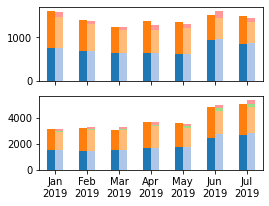

In [51]:
caltech_online = pd.DataFrame(online_data['caltech']).T
caltech_online.index = pd.to_datetime(caltech_online.index)


jpl_online = pd.DataFrame(online_data['jpl']).T
jpl_online.index = pd.to_datetime(jpl_online.index)

fig2, axes2 = plt.subplots(2, figsize=(4, 3), sharex=True)
plot_cost_rev_online(caltech_offline, caltech_online, axes2[0])
plot_cost_rev_online(jpl_offline, jpl_online, axes2[1])

axes2[1].set_xticklabels([pandas_datetime.strftime("%b\n%Y") for pandas_datetime in caltech_offline.index])
axes2[1].set_xlabel('')
pass

In [98]:
fig2.savefig('online_revenue.pdf', dpi=300)

#### Online Surpluses

Note that unlike the offline case. Online surpluses can be positive or negative. This is because the user prices are calculated based on an offline optimal schedule, while the charging schedules are calculated with only causal information. 

In [52]:
print('Caltech Operator Surplus (Online)')
caltech_online_surplus = caltech_offline['revenue.total'] - caltech_online['total_cost']
pprint(caltech_online_surplus)
print(sum(caltech_online_surplus))
print(sum(caltech_online_surplus) / caltech_offline['revenue.total'].sum())

Caltech Operator Surplus (Online)
2019-01-01    -13.077074
2019-02-01     -3.385319
2019-03-01     -9.664305
2019-04-01   -105.489877
2019-05-01    -37.550737
2019-06-01     94.242014
2019-07-01    -53.934572
dtype: float64
-128.8598704524518
-0.013083196703229051


In [53]:
print('JPL Operator Surplus (Online)')
jpl_online_surplus = jpl_offline['revenue.total'] - jpl_online['total_cost']
pprint(jpl_online_surplus)
sum(jpl_online_surplus) 
print(sum(jpl_online_surplus))
print(sum(jpl_online_surplus) / jpl_offline['revenue.total'].sum())

JPL Operator Surplus (Online)
2019-01-01     -6.588354
2019-02-01     67.821893
2019-03-01    194.843259
2019-04-01    -56.339208
2019-05-01    -92.935289
2019-06-01    186.914510
2019-07-01    352.817019
dtype: float64
646.5338301235065
0.023724721788285916


In [54]:
print('Caltech Surcharges')
pprint(caltech_online_surplus / caltech_offline['revenue.energy_requested'])

Caltech Surcharges
2019-01-01   -0.001281
2019-02-01   -0.000365
2019-03-01   -0.001087
2019-04-01   -0.011999
2019-05-01   -0.004456
2019-06-01    0.013118
2019-07-01   -0.008167
dtype: float64


In [55]:
print('JPL Surcharges')
pprint(jpl_online_surplus / jpl_offline['revenue.energy_requested'])

JPL Surcharges
2019-01-01   -0.000333
2019-02-01    0.003574
2019-03-01    0.009359
2019-04-01   -0.002522
2019-05-01   -0.004019
2019-06-01    0.009330
2019-07-01    0.016475
dtype: float64


#### Optimality Gap

Because online scheduling must be done with only causal information, there is almost always a gap between the offline optimal and the cost incurred by the online scheduling algorithm. In our case this gap is on average 10.8% for Caltech and 8.3% for JPL. 

In [62]:
print('Caltech Percent Difference Offline v. Online')
percent_diff = ((caltech_offline['costs.total_cost'] - pd.DataFrame(online_data['caltech']).T['total_cost']) / caltech_offline['costs.total_cost'])*100
pprint(percent_diff)

print()
print('Aggregate Percent Difference')
print((caltech_offline['costs.total_cost'].sum() - caltech_online['total_cost'].sum())/caltech_offline['costs.total_cost'].sum())

Caltech Percent Difference Offline v. Online
2019-01-01    -8.586036
2019-02-01    -6.570202
2019-03-01    -6.308015
2019-04-01   -16.777013
2019-05-01   -10.892589
2019-06-01    -4.862286
2019-07-01   -11.345391
dtype: float64

Aggregate Percent Difference
-0.09187574583598303


In [63]:
print('JPL Percent Difference Offline v. Online')
percent_diff = ((jpl_offline['costs.total_cost'] - jpl_online['total_cost']) / jpl_offline['costs.total_cost'])*100
pprint(percent_diff)

print()
print('Aggregate Percent Difference')
print((jpl_offline['costs.total_cost'].sum() - jpl_online['total_cost'].sum())/jpl_offline['costs.total_cost'].sum())

JPL Percent Difference Offline v. Online
2019-01-01    -6.733976
2019-02-01    -6.506220
2019-03-01    -0.647676
2019-04-01   -10.108115
2019-05-01   -10.526519
2019-06-01    -6.294475
2019-07-01    -5.023791
dtype: float64

Aggregate Percent Difference
-0.06500401228846624


#### Overall Online Results

In [64]:
caltech_online

,proportion_delivered,demands_fully_met,peak_current,demand_charge,energy_cost,total_cost
2019-01-01,99.999778,100.0,262.117682,845.612613,756.032645,1601.645258
2019-02-01,99.999831,100.0,215.800572,696.189910,691.841464,1388.031375
2019-03-01,99.999793,100.0,184.880884,596.440522,650.548336,1246.988859
2019-04-01,99.999843,100.0,226.377657,730.312432,648.160838,1378.473270
2019-05-01,99.999861,100.0,222.566194,718.016347,628.228958,1346.245305
2019-06-01,99.999882,100.0,179.156141,577.972043,939.674779,1517.646822
2019-07-01,99.999850,100.0,198.533084,640.483613,858.610299,1499.093912


In [65]:
jpl_online

,proportion_delivered,demands_fully_met,peak_current,demand_charge,energy_cost,total_cost
2019-01-01,99.991263,99.562682,498.498131,1608.194850,1507.326300,3115.521150
2019-02-01,99.982424,99.378882,561.765314,1812.299843,1445.390565,3257.690408
2019-03-01,99.997338,99.857041,469.290865,1513.969875,1570.783301,3084.753176
2019-04-01,99.984336,99.606299,621.690478,2005.623218,1700.734564,3706.357781
2019-05-01,99.988637,99.574209,574.237333,1852.535575,1745.597831,3598.133406
2019-06-01,99.995401,99.783237,735.528283,2372.873085,2433.075913,4805.948997
2019-07-01,99.994864,99.731363,736.373518,2375.599878,2660.943430,5036.543308


## Combined Plot

In this plot we should the offline optimal cost (left), online cost (middle), and revenue (right) for each montha nd each site. 

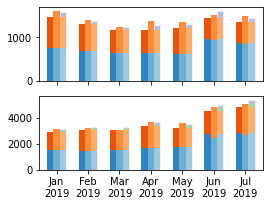

In [66]:
fig3, axes3 = plt.subplots(2, figsize=(4, 3), sharex=True)
plot_cost_rev_online_offline(caltech_offline, caltech_online, axes3[0], 0.5, 0.6)
plot_cost_rev_online_offline(jpl_offline, jpl_online, axes3[1], 0.5, 0.6)

axes3[1].set_xticklabels([pandas_datetime.strftime("%b\n%Y") for pandas_datetime in caltech_offline.index])
axes3[1].set_xlabel('')
pass

## Pricing Distribution

In this section we examine the distribution of prices among sessions and users. While we want to attribute costs, such as demand charges, to those users which cause them, it is not desirable to have some users paying a much higher price per kWh than others. 

In [69]:
EXPERIMENT_DIR = 'results/offline_prices/'

dates = [f'{m}-1-2019' for m in range(1, 9)] 
sites = ['caltech', 'jpl']
tariff_name = 'sce_tou_ev_4_march_2019'

data = dict()
for site in sites:
    data[site] = dict()
    for start in dates[:-1]:
        path = EXPERIMENT_DIR + f'{tariff_name}/{site}/{start}/'
        with open(path + 'session_rev.json', 'r') as f:
            data[site][start] = json.load(f)   

In [70]:
caltech_sessions = []
for start in data['caltech']:
    d = pd.DataFrame(data['caltech'][start]).T
    d['start'] = start
    d['$/kWh'] = d['session_price'] / d['energy_requested']
    caltech_sessions.append(d)
caltech_sessions = pd.concat(caltech_sessions)

In [79]:
print('Max price paid per session: Caltech')
pprint(caltech_sessions.groupby('start')['$/kWh'].max())
print(len(caltech_sessions))

Max price paid per session: Caltech
start
1-1-2019    1.629417
2-1-2019    1.523208
3-1-2019    1.553996
4-1-2019    1.395331
5-1-2019    1.426369
6-1-2019    0.762601
7-1-2019    0.751764
Name: $/kWh, dtype: float64
6579


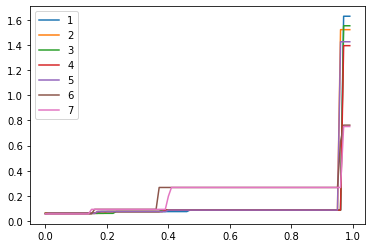

In [102]:
fig, ax = plt.subplots()
for i in range(1, 8):
    caltech_sessions.query(f'start == "{i}-1-2019"')['$/kWh'].quantile(np.arange(0, 1, 0.01)).plot(label=i, ax=ax)
plt.legend()

(0.0, 0.3)

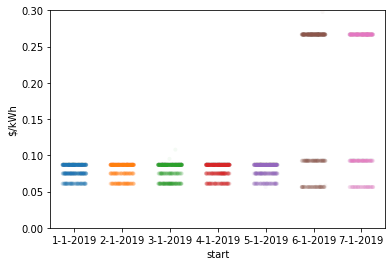

In [103]:
import seaborn as sns
p = sns.stripplot(data=caltech_sessions, x='start', y='$/kWh', alpha=0.05, jitter=0.25, size=4)
plt.ylim(0, 0.3)

In [74]:
jpl_sessions = []
for start in data['caltech']:
    d = pd.DataFrame(data['jpl'][start]).T
    d['start'] = start
    d['$/kWh'] = d['session_price'] / d['energy_requested']
    jpl_sessions.append(d)
jpl_sessions = pd.concat(jpl_sessions)

In [106]:
print('Max price paid per session: JPL')
pprint(jpl_sessions.groupby('start')['$/kWh'].max())
print(len(jpl_sessions))

Max price paid per session: JPL
start
1-1-2019    1.492940
2-1-2019    1.535782
3-1-2019    1.448048
4-1-2019    1.482491
5-1-2019    1.365029
6-1-2019    0.266682
7-1-2019    0.266681
Name: $/kWh, dtype: float64
10100


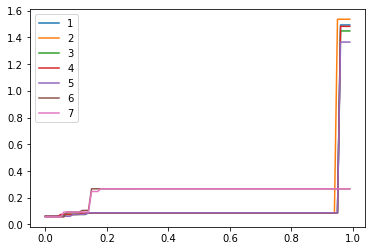

In [108]:
fig, ax = plt.subplots()
for i in range(1, 8):
    jpl_sessions.query(f'start == "{i}-1-2019"')['$/kWh'].quantile(np.arange(0, 1, 0.01)).plot(label=i, ax=ax)
plt.legend()

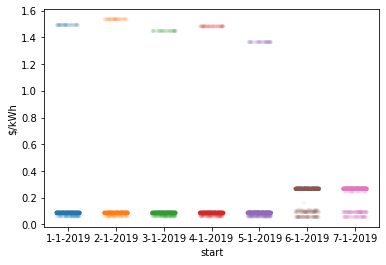

In [107]:
p = sns.stripplot(data=jpl_sessions, x='start', y='$/kWh', alpha=0.05, jitter=0.25, size=4)

In [109]:
with open('sessions_by_user.json', 'r') as f:
    sessions_by_user = json.load(f)

In [110]:
def blended_price(sessions, sess_by_uid, min_session_count=0):
    blended = []
    for start in sess_by_uid:
        for user, u_sessions in sess_by_uid[start].items():
            if len(u_sessions) > min_session_count:
                _paid = sessions.T[u_sessions].T['total'].sum()
                _energy = sessions.T[u_sessions].T['energy_delivered'].sum()
                blended.append({'start': start, 'user': user, '$/kWh': _paid / _energy})
    return pd.DataFrame(blended)

In [ ]:
caltech_blended = pd.DataFrame(blended_price(caltech_sessions, sessions_by_user['caltech']))

In [ ]:
p = sns.stripplot(data=caltech_blended, x='start', y='$/kWh', alpha=0.05, jitter=0.25, size=4)